In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import os

imagedir = 'images'
if not os.path.isdir(imagedir):
    os.mkdir(imagedir)
# For numeric stability
EPSILON = 1e-10

df = pd.read_csv('ListingsAndSales.csv')

# not sold flag
df['NotSoldFlag'] = 0
df.loc[df['SalesDate'].isnull() == True, 'NotSoldFlag'] = 1
print('percent not yet sold:', df['NotSoldFlag'].mean())

df.ListingDate, df.SalesDate = [
    pd.to_datetime(col) for col in [df.ListingDate, df.SalesDate]
]
df.SalesDate = df.SalesDate.fillna(df.SalesDate.max())

# Get day of dataset for each sample
df['ListingDay'] = (df.ListingDate - df.ListingDate.min()).dt.days
df = df.sort_values('ListingDay')

# calculate days it took to sell the listing if it's sold
df['DaysSold'] = (df.SalesDate - df.ListingDate).dt.days.astype(float) + 1

# loop through the variables and replace missing values with avg and create dummy variables
col_dates = ['ListingDate', 'SalesDate']
for col in df.columns:
    if not col in col_dates:
        if df[col].isnull().sum(axis=0) > 0:
            df[col + "_null_flag"] = (df[col].isnull())
            col_avg = df.loc[df[col].isnull() == False, col].mean()
            df[col] = df[col].fillna(col_avg)

# Columns to use as regressors
X = df.drop(['DaysSold', 'ListingDate', 'SalesDate', 'NotSoldFlag'], axis=1)

# Column to use as target
Y = df[['DaysSold']].as_matrix().astype(np.float32)

scaler = StandardScaler()
X = pd.DataFrame(
    scaler.fit_transform(X), columns=X.columns).as_matrix().astype(np.float32)
sold = df['NotSoldFlag'].as_matrix().astype(np.float32)
n_features = X.shape[1]


class Model():
    def __init__(self, input_size, layer_sizes):
        self.input_size = input_size
        self.layer_sizes = layer_sizes

        self.sold = tf.placeholder(tf.float32, shape=(None))
        self.x = tf.placeholder(tf.float32, shape=(None, input_size))
        self.y = tf.placeholder(tf.float32, shape=(None))

        self.layers = [self.x]
        for layer_size in layer_sizes:
            next_layer = tf.nn.leaky_relu(
                tf.layers.dense(self.layers[-1], layer_size))
            self.layers.append(next_layer)

        self.output = tf.nn.softplus(tf.layers.dense(self.layers[-1], 1))

        self.loss_indicator = (tf.cast(self.output < self.y, tf.float32) *
                               (1 - self.sold) + self.sold)
        loss_numerator = tf.reduce_sum(
            tf.square(self.y - self.output) * self.loss_indicator)
        loss_denominator = (tf.reduce_sum(self.loss_indicator)) + EPSILON
        self.loss = loss_numerator / loss_denominator

        self.optimizer = tf.train.AdamOptimizer().minimize(self.loss)

        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())

        self.trn_losses = []
        self.val_losses = []
        self.r2_scores = []

    def train_one_epoch(self, trn_samples, bs, X_train, Y_train, sold_train):
        # Train an epoch
        trn_loss = []
        # Randomly shuffle data and prepare for training
        order = np.arange(trn_samples)
        np.random.shuffle(order)
        num_batches = (trn_samples // bs) + 1
        for itr in range(trn_samples // bs):
            rows = order[itr * bs:(itr + 1) * bs]
            if itr + 1 == num_batches:
                rows = order[itr * bs:]
            X_active, Y_active, Sold_active = [
                mat[rows] for mat in [X_train, Y_train, sold_train]
            ]
            feed_dict = {
                self.x: X_active,
                self.y: Y_active,
                self.sold: Sold_active
            }
            _, loss = self.sess.run([self.optimizer, self.loss], feed_dict)
            trn_loss.append(loss)
        self.trn_losses.append(np.mean(trn_loss))

    def validate(self, X_test, Y_test, sold_test):
        feed_dict = {self.x: X_test, self.y: Y_test, self.sold: sold_test}
        val_loss, yhat = self.sess.run([self.loss, self.output], feed_dict)
        self.val_losses.append(val_loss)
        self.r2_scores.append(r2_score(Y_test, yhat))

    def train(self, X, Y, sold, epochs):
        # Train the model based on X,Y,sold data for a set number of epochs
        n_samples = X.shape[0]
        trn_samples = (n_samples * 4) // 5
        bs = 64
        
        # Let's randomly split the data here between train and test.
        # We will do better in a later version.
        samples = np.arange(n_samples)
        trn_s = np.random.choice(samples, size=trn_samples, replace=False)
        val_samples = [s for s in samples if s not in trn_s]
        X_train, X_test = X[trn_s], X[val_samples]
        Y_train, Y_test = Y[trn_s], Y[val_samples]
        sold_train, sold_test = sold[trn_s], sold[val_samples]

        # Everything is set. Now train and validate
        for epoch in range(epochs):
            # run one epoch train and validation
            self.train_one_epoch(trn_samples, bs, X_train, Y_train, sold_train)
            self.validate(X_test, Y_test, sold_test)
            
            if epoch % 10 == 0:
                # Occasionally print to command line to inspect performance
                print('epoch:', epoch, 'train loss: ', self.trn_losses[-1],
                      'val loss: ', self.val_losses[-1], 'r2_score:',
                      self.r2_scores[-1])

    def visualize(self, name):
        # Visualize training and validation losses and r2 scores on one plot
        _, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.plot(self.trn_losses, label='train loss')
        ax1.plot(self.val_losses, label='test loss')
        ax2.plot(self.r2_scores, label='validation r2_scores', color='g')
        ax1.set_xlabel('epochs')
        ax1.set_ylabel('least square losses')
        ax2.set_ylabel('R2 Scores')
        ax2.legend()
        ax1.legend()
        plt.title('Losses and r2 scores for ' + name)
        plt.savefig(imagedir + '/' + name + '.jpg')
        plt.show()


/home/lee/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


percent not yet sold: 0.6864035087719298


epoch: 0 train loss:  730.2181 val loss:  735.13904 r2_score: -0.08719582507859158
epoch: 10 train loss:  655.4984 val loss:  657.1021 r2_score: 0.022697829884227416
epoch: 20 train loss:  579.7889 val loss:  582.4101 r2_score: 0.12554481018059682
epoch: 30 train loss:  519.5005 val loss:  523.47406 r2_score: 0.2071584506169295
epoch: 40 train loss:  470.5264 val loss:  476.4449 r2_score: 0.2736947153927276
epoch: 50 train loss:  433.13077 val loss:  438.95917 r2_score: 0.32836261492798713
epoch: 60 train loss:  400.92813 val loss:  407.46878 r2_score: 0.37370162665039275
epoch: 70 train loss:  375.21457 val loss:  382.8659 r2_score: 0.411000141969727
epoch: 80 train loss:  354.64438 val loss:  362.40472 r2_score: 0.4413475505180853
epoch: 90 train loss:  338.1872 val loss:  345.53607 r2_score: 0.466115415017221


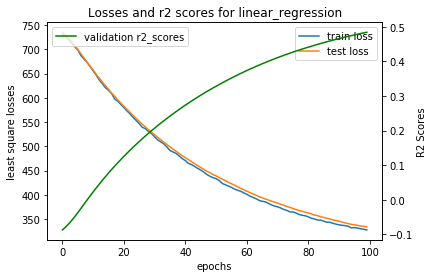

In [2]:
model = Model(n_features, layer_sizes=[])
model.train(X, Y, sold, epochs=100)
model.visualize('linear_regression')

epoch: 0 train loss:  712.7342 val loss:  650.37305 r2_score: 0.015211737173718154
epoch: 10 train loss:  215.68346 val loss:  226.52684 r2_score: 0.6225063632019141
epoch: 20 train loss:  188.54137 val loss:  196.24475 r2_score: 0.6629467058184794
epoch: 30 train loss:  176.75809 val loss:  185.84293 r2_score: 0.6769416977988469
epoch: 40 train loss:  172.26706 val loss:  180.91162 r2_score: 0.6841973177457346
epoch: 50 train loss:  170.33878 val loss:  179.18118 r2_score: 0.6858619924259819
epoch: 60 train loss:  170.27487 val loss:  177.34918 r2_score: 0.688467784481881
epoch: 70 train loss:  169.63716 val loss:  176.02846 r2_score: 0.6899328999542762
epoch: 80 train loss:  168.58394 val loss:  176.04488 r2_score: 0.6903147711849569
epoch: 90 train loss:  167.9672 val loss:  174.11497 r2_score: 0.6925905117680231


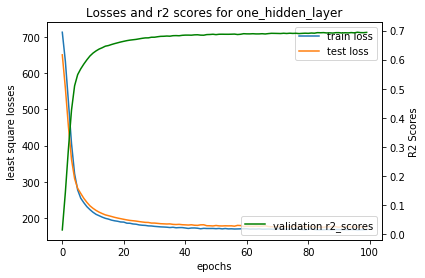

In [3]:
model = Model(n_features, layer_sizes=[64])
model.train(X, Y, sold, epochs=100)
model.visualize('one_hidden_layer')

epoch: 0 train loss:  665.13403 val loss:  529.2562 r2_score: 0.19934734009535005
epoch: 10 train loss:  175.78087 val loss:  179.28848 r2_score: 0.6898073779979665
epoch: 20 train loss:  168.66953 val loss:  176.68839 r2_score: 0.6947320813150597
epoch: 30 train loss:  167.11395 val loss:  173.95282 r2_score: 0.6984181171292587
epoch: 40 train loss:  166.03711 val loss:  169.64407 r2_score: 0.7013651694386884
epoch: 50 train loss:  163.69096 val loss:  172.96214 r2_score: 0.701982998167387
epoch: 60 train loss:  162.49722 val loss:  168.60878 r2_score: 0.7041656905352218
epoch: 70 train loss:  164.17982 val loss:  175.66872 r2_score: 0.6971327190648352
epoch: 80 train loss:  161.05312 val loss:  168.72966 r2_score: 0.7057602568966482
epoch: 90 train loss:  159.80951 val loss:  168.06212 r2_score: 0.7066165081577015


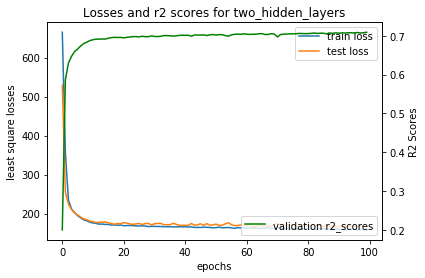

In [4]:
model = Model(n_features, layer_sizes=[64, 64])
model.train(X, Y, sold, epochs=100)
model.visualize('two_hidden_layers')